# ⚡️ Introduction to JAX — Chris's Notes

## Contents

- [0. Introduction](#0-Introduction)
- [1. JAX as a NumPy Replacement](#1-JAX-as-a-NumPy-Replacement)
- [2. Random Numbers — split / fold_in](#2-Random-Numbers--splitfold_in)
- [3. JIT Compilation — @jax.jit](#3-JIT-Compilation--@jaxjit)
- [4. Functional Programming — Pure Functions](#4-Functional-Programming--Pure-Functions)
- [5. Gradients — Automatic Differentiation](#5-Gradients--Automatic-Differentiation)
- [6. Vectorized Code — jnp.meshgrid & jax.vmap](#6-Vectorized-Code--jnpmeshgrid--jaxvmap)
- [7. Implement — Monte Carlo Option Pricing in JAX](#7-Implement--Monte-Carlo-Option-Pricing-in-JAX)


## 0. Introduction


### What is JAX?

> JAX is a high-performance numerical computing library that extends NumPy with  
**automatic differentiation**, **GPU/TPU acceleration**, and **just-in-time (JIT) compilation**.  
Although popular in deep learning, JAX is fundamentally a general tool for scientific and
economic computation.





### Why JAX?

>Modern deep learning — and many computational economic tasks — rely on three capabilities:
>1. **Parallelization** on accelerators  
2. **Automatic differentiation**  
3. **Fast compiled execution** via JIT  

>**JAX provides all three in a single NumPy-like framework**, giving deep-learning-level
performance for tasks such as DSGE modeling, quantitative macro, structural estimation, and
large-scale simulation.





### In short

>**JAX = NumPy feel + deep learning speed**

## 1. JAX as a NumPy Replacement


One way to use JAX is as a plug-in NumPy replacement. Let’s look at the
similarities and differences.

### Similarities

The following import is standard, replacing `import numpy as np`:

In [12]:
import jax
import numpy as np
import jax.numpy as jnp
#Now we can use jnp in place of np for the usual array operations:

In [13]:
a = jnp.asarray((1.0, 3.2, -1.5))

In [14]:
print(a)
print(jnp.sum(a))
print(jnp.mean(a))
print(jnp.dot(a,a))

#totally same with NumPy

[ 1.   3.2 -1.5]
2.7
0.90000004
13.490001


However, the array object `a` is not a NumPy array:

In [15]:
a

Array([ 1. ,  3.2, -1.5], dtype=float32)

In [16]:
type(a)


jaxlib.xla_extension.ArrayImpl

Even scalar-valued maps on arrays return JAX arrays

In [17]:
x = np.array([1.0, 2.0, 3.0])
np.sum(x)


6.0

In [18]:
a = jnp.asarray([1.0, 2.0, 3.0])
jnp.sum(a)


Array(6., dtype=float32)

Operations on higher dimensional arrays are also similar to NumPy:

In [19]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [20]:
from jax.numpy import linalg

In [21]:
linalg.inv(B)   # Inverse of identity is identity

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [22]:
out = linalg.eigh(B)  # Computes eigenvalues and eigenvectors
eigenvalues, eigenvectors = out
eigenvalues

Array([1., 1.], dtype=float32)

In [23]:
eigenvectors

Array([[1., 0.],
       [0., 1.]], dtype=float32)

### Differences

One difference between NumPy and JAX is that JAX currently uses 32 bit floats by default.

This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, for some calculations precision matters.  In these cases 64 bit floats can be enforced via the command

In [24]:
jax.config.update("jax_enable_x64", True)

In [25]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float64)

As a NumPy replacement, a more significant difference is that arrays are treated as **immutable**.

For example, with NumPy we can write

In [26]:
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [27]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails:

In [28]:
a = jnp.linspace(0, 1, 3)
a

Array([0. , 0.5, 1. ], dtype=float64)

In [29]:
#a[0] = 1  #erro cuz immutable jax

JAX arrays are **immutable**, so operations like `a[0] = 1` are not allowed. Instead, JAX provides the functional update API `a.at[0].set(1)`, which returns a **new array** with the update applied while keeping the **original array un**


In [30]:
a = jnp.linspace(0, 1, 3)
id(a)

140451477850032

In [31]:
a = a.at[0].set(1)
a

Array([1. , 0.5, 1. ], dtype=float64)

In [32]:
id(a)

140451602670944

## 2. Random Numbers — split / fold_in



Random numbers are also a bit different in JAX, relative to NumPy.  Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

In [33]:
import jax.random as random

In [34]:
key = random.PRNGKey(1) #produce a key which seeds the random number generator

In [35]:
print(key)

[0 1]


In [36]:
x = random.normal(key, (3,3)) #(PRNGKey, Shape)
x

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

In [37]:
random.normal(key, (3,3)) #use same key ---> initialize at the same seed
#So the random number are the same

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

To produce a (quasi-) independent draw, we can **`split`** the existing key.

In [38]:
key, subkey = random.split(key)

In [39]:
random.normal(key, (3, 3))

Array([[ 1.85374374, -0.37683949, -0.61276867],
       [-1.91829718,  0.27219409,  0.54922246],
       [ 0.40451442, -0.58726839, -0.63967753]], dtype=float64)

In [40]:
random.normal(subkey, (3, 3))

Array([[-0.4300635 ,  0.22778552,  0.57241269],
       [-0.15969178,  0.46719192,  0.21165091],
       [ 0.84118631,  1.18671326, -0.16607783]], dtype=float64)

As we will see, the `split` operation is particularly useful for parallel
computing, where independent sequences or simulations can be given their own
key.

Another option is `fold_in`, which produces new “independent” keys from a base
key.

The function below produces `k` (quasi-) independent random `n x n` matrices using this procedure.

In [41]:
base_key = random.PRNGKey(42)
def gen_random_matrices(key, n, k):
    matrices = []
    for i in range(k):
        key = random.fold_in(base_key, i)  # generate a fresh key
        matrices.append(random.normal(key, (n, n)))
    return matrices

In [42]:
matrices = gen_random_matrices(key, 2, 3)
for A in matrices:
    print(A)

[[ 1.46095216 -0.39109681]
 [-0.11408238 -1.11578903]]
[[ 1.69459329 -0.26653727]
 [-0.01332643  0.50077897]]
[[0.55479997 0.27176499]
 [0.74969541 1.26965753]]


## 3. JIT Compilation — @jax.jit



The JAX just-in-time (JIT) compiler accelerates logic within functions by fusing linear
algebra operations into a single optimized kernel that the host can
launch on the GPU / TPU (or CPU if no accelerator is detected).

### A first example

To see the JIT compiler in action, consider the following function.

In [43]:
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

Let’s build an array to call the function on.

In [44]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [45]:
%time f(x).block_until_ready()

CPU times: user 5.86 s, sys: 3.51 s, total: 9.37 s
Wall time: 3.95 s


Array(2.19896006e+08, dtype=float64)

>**Note**
>
>Here, in order to measure actual speed, we use the `block_until_ready()` method
to hold the interpreter until the results of the computation are returned from
the device. This is necessary because JAX uses asynchronous dispatch, which
allows the Python interpreter to run ahead of GPU computations.

The code doesn’t run as fast as we might hope, given that it’s running on a GPU.

But if we run it a second time it becomes much faster:

In [46]:
%time f(x).block_until_ready()

CPU times: user 5.5 s, sys: 3.41 s, total: 8.91 s
Wall time: 3.53 s


Array(2.19896006e+08, dtype=float64)

This is because the built in functions like `jnp.cos` are JIT compiled and the
first run includes compile time.

Why would JAX want to JIT-compile built in functions like `jnp.cos` instead of
just providing pre-compiled versions, like NumPy?

The reason is that the JIT compiler can specialize on the *size* of the array
being used, which is helpful for parallelization.

For example, in running the code above, the JIT compiler produced a version of `jnp.cos` that is
specialized to floating point arrays of size `n = 50_000_000`.

We can check this by calling `f` with a new array of different size.

In [47]:
m = 50_000_001
y = jnp.ones(m)

In [48]:
%time f(y).block_until_ready()

CPU times: user 5.8 s, sys: 3.56 s, total: 9.36 s
Wall time: 3.86 s


Array(2.19896011e+08, dtype=float64)

Notice that the execution time increases, because now new versions of
the built-ins like `jnp.cos` are being compiled, specialized to the new array
size.

If we run again, the code is dispatched to the correct compiled version and we
get faster execution.

In [49]:
%time f(y).block_until_ready()

CPU times: user 5.56 s, sys: 3.48 s, total: 9.04 s
Wall time: 3.63 s


Array(2.19896011e+08, dtype=float64)

The compiled versions for the previous array size are still available in memory
too, and the following call is dispatched to the correct compiled code.

In [50]:
%time f(x).block_until_ready()

CPU times: user 5.46 s, sys: 3.55 s, total: 9.01 s
Wall time: 3.49 s


Array(2.19896006e+08, dtype=float64)

### Compiling the outer function

We can do even better if we manually JIT-compile the outer function.

In [51]:
f_jit = jax.jit(f)   # target for JIT compilation

Let’s run once to compile it:

In [52]:
f_jit(x)

Array(2.19896006e+08, dtype=float64)

And now let’s time it.

In [53]:
%time f_jit(x).block_until_ready()

CPU times: user 3.39 s, sys: 331 ms, total: 3.72 s
Wall time: 1.72 s


Array(2.19896006e+08, dtype=float64)

Note the speed gain.

This is because the array operations are fused and no intermediate arrays are created.

Incidentally, a more common syntax when targetting a function for the JIT
compiler is

In [54]:
@jax.jit
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

## 4. Functional Programming — Pure Functions



From JAX’s documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.

A pure function will always return the same result if invoked with the same inputs.

In particular, a pure function has

- no dependence on global variables and  
- no side effects  


JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here’s an illustration of this fact, using global variables:

In [55]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [56]:
x = jnp.ones(2)

In [57]:
f(x)

Array([2., 2.], dtype=float64)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected — as long as the same compiled version is called.

In [58]:
a = 42

In [59]:
f(x)

Array([2., 2.], dtype=float64)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of `a` takes effect:

In [60]:
x = jnp.ones(3)

In [61]:
f(x)

Array([43., 43., 43.], dtype=float64)

Moral of the story: write pure functions when using JAX!

In [62]:
#like
def f(a,x):
    return a+x

x=jnp.ones(2)
a = 3
f(a,x)

Array([4., 4.], dtype=float64)

## 5. Gradients — Automatic Differentiation





JAX can use automatic differentiation to compute gradients.

This can be extremely useful for optimization and solving nonlinear systems.

In [63]:
def f(x):
    return (x**2) / 2

Let’s take the derivative:

In [64]:
f_prime = jax.grad(f)

In [65]:
f_prime(10.0)

Array(10., dtype=float64, weak_type=True)

Let’s plot the function and derivative, noting that $ f'(x) = x $.

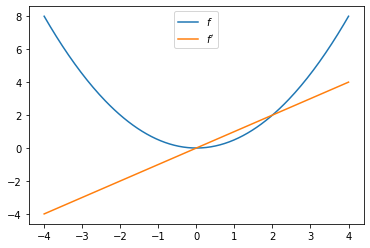

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()

We defer further exploration of automatic differentiation with JAX until [Adventures with Autodiff](https://jax.quantecon.org/autodiff.html).

## 6. Vectorized Code — jnp.meshgrid & jax.vmap



Writing fast JAX code requires shifting repetitive tasks from loops to array processing operations, so that the JAX compiler can easily understand the whole operation and generate more efficient machine code.

This procedure is called **vectorization** or **array programming**, and will be familiar to anyone who has used NumPy or MATLAB.

In most ways, vectorization is the same in JAX as it is in NumPy.

But there are also some differences, which we highlight here.

As a running example, consider the function

$$
f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
$$

Suppose that we want to evaluate this function on a square grid of $ x $ and $ y $ points and then plot it.

To clarify, here is the slow `for` loop version.

In [67]:
@jax.jit
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2)

n = 80
x = jnp.linspace(-2, 2, n)
y = x

z_loops = np.empty((n, n))

In [68]:
%%time
for i in range(n):
    for j in range(n):
        z_loops[i, j] = f(x[i], y[j])

CPU times: user 5.26 s, sys: 111 ms, total: 5.37 s
Wall time: 6.19 s


Even for this very small grid, the run time is extremely slow.

(Notice that we used a NumPy array for `z_loops` because we wanted to write to it.)

OK, so how can we do the same operation in vectorized form?

If you are new to vectorization, you might guess that we can simply write

In [69]:
z_bad = f(x, y)

But this gives us the wrong result because JAX doesn’t understand the nested for loop.

In [70]:
z_bad.shape

(80,)

Here is what we actually wanted:

In [71]:
z_loops.shape

(80, 80)

To get the right shape and the correct nested for loop calculation, we can use a `meshgrid` operation designed for this purpose:

In [72]:
x_mesh, y_mesh = jnp.meshgrid(x, y)

Now we get what we want and the execution time is very fast.

In [73]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 51 ms, sys: 4.28 ms, total: 55.3 ms
Wall time: 59.4 ms


Let’s run again to eliminate compile time.

In [74]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 363 µs, sys: 135 µs, total: 498 µs
Wall time: 409 µs


Let’s confirm that we got the right answer.

In [75]:
jnp.allclose(z_mesh, z_loops)

Array(True, dtype=bool)

Now we can set up a serious grid and run the same calculation (on the larger grid) in a short amount of time.

In [76]:
n = 6000
x = jnp.linspace(-2, 2, n)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)

In [77]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 1.18 s, sys: 218 ms, total: 1.4 s
Wall time: 740 ms


Let’s run again to get rid of compile time.

In [78]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 1.14 s, sys: 263 ms, total: 1.4 s
Wall time: 616 ms


But there is one problem here: the mesh grids use a lot of memory.

In [79]:
x_mesh.nbytes + y_mesh.nbytes

576000000

By comparison, the flat array `x` is just

In [80]:
x.nbytes  # and y is just a pointer to x

48000

This extra memory usage can be a big problem in actual research calculations.

So let’s try a different approach using [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)

First we vectorize `f` in `y`.

In [81]:
f_vec_y = jax.vmap(f, in_axes=(None, 0))

In the line above, `(None, 0)` indicates that we are vectorizing in the second argument, which is `y`.

Next, we vectorize in the first argument, which is `x`.

In [82]:
f_vec = jax.vmap(f_vec_y, in_axes=(0, None))

With this construction, we can now call the function $ f $ on flat (low memory) arrays.

In [83]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

CPU times: user 930 ms, sys: 215 ms, total: 1.15 s
Wall time: 559 ms


We run it again to eliminate compile time.

In [84]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

CPU times: user 877 ms, sys: 243 ms, total: 1.12 s
Wall time: 628 ms


The execution time is essentially the same as the mesh operation but we are using much less memory.

And we produce the correct answer:

In [85]:
jnp.allclose(z_vmap, z_mesh)

Array(True, dtype=bool)

## 7. Implement — Monte Carlo Option Pricing in JAX

Earlier, in the Numba + parallelization lecture, we priced a European
call option using a Monte Carlo simulation accelerated with Numba’s
multithreading.

Here, I re-implement the same Monte Carlo procedure in **JAX**
using exactly the same model parameters. The goal is to compare the JAX
version with the Numba version.

Since JAX can JIT-compile the computation and run it on the GPU
(if available), the JAX implementation should achieve noticeably faster
execution, especially for a large number of simulation paths.


In [86]:
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=M,
                           key=jax.random.PRNGKey(1)):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))

    return β**n * expectation

run it once to compile it:

In [87]:
%%time
compute_call_price_jax().block_until_ready()

CPU times: user 1min 14s, sys: 5.61 s, total: 1min 19s
Wall time: 35.2 s


Array(180876.48840921, dtype=float64)

And now time it:

In [88]:
%%time
compute_call_price_jax().block_until_ready()

CPU times: user 1min, sys: 3.88 s, total: 1min 4s
Wall time: 23.9 s


Array(180876.48840921, dtype=float64)